In [1]:
import os
import sys

os.environ["SPARK_HOME"] = "/opt/spark"
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib'))

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").getOrCreate()
assert spark.range(5).rdd.flatMap(lambda x: x).sum() == 10

In [12]:
from pyspark.sql.functions import conv
spark.range(3000, 3030).select("id", *[conv("id", 10, n).alias(str(n)) for n in range(2, 17)]).show()

+----+------------+--------+------+-----+-----+-----+----+----+----+----+----+----+----+---+---+
|  id|           2|       3|     4|    5|    6|    7|   8|   9|  10|  11|  12|  13|  14| 15| 16|
+----+------------+--------+------+-----+-----+-----+----+----+----+----+----+----+----+---+---+
|3000|101110111000|11010010|232320|44000|21520|11514|5670|4103|3000|2288|18A0|149A|1144|D50|BB8|
|3001|101110111001|11010011|232321|44001|21521|11515|5671|4104|3001|2289|18A1|149B|1145|D51|BB9|
|3002|101110111010|11010012|232322|44002|21522|11516|5672|4105|3002|228A|18A2|149C|1146|D52|BBA|
|3003|101110111011|11010020|232323|44003|21523|11520|5673|4106|3003|2290|18A3|14A0|1147|D53|BBB|
|3004|101110111100|11010021|232330|44004|21524|11521|5674|4107|3004|2291|18A4|14A1|1148|D54|BBC|
|3005|101110111101|11010022|232331|44010|21525|11522|5675|4108|3005|2292|18A5|14A2|1149|D55|BBD|
|3006|101110111110|11010100|232332|44011|21530|11523|5676|4110|3006|2293|18A6|14A3|114A|D56|BBE|
|3007|101110111111|11010101|23

In [11]:
from pyspark.sql.functions import count, length, desc, sum
from pyspark.sql import Window
cart = spark.read.csv("/usr/share/dict/american-english")
cart.select(length(cart[0]).alias("len"))\
    .groupby("len")\
    .agg(count("len").alias("freq"))\
    .withColumn("cumul", sum("freq").over(Window.orderBy("freq").rowsBetween(Window.unboundedPreceding, Window.currentRow)))\
    .sort(desc("len"))\
    .show()

+---+-----+-----+
|len| freq|cumul|
+---+-----+-----+
| 23|    1|    1|
| 22|    5|    9|
| 21|    3|    4|
| 20|   10|   19|
| 19|   31|   50|
| 18|   72|  174|
| 17|  176|  350|
| 16|  381|  913|
| 15|  890| 2649|
| 14| 1676| 4325|
| 13| 3234| 7559|
| 12| 5502|16413|
| 11| 8408|31620|
| 10|11529|54451|
|  9|14248|68699|
|  8|15684|99171|
|  7|14788|83487|
|  6|11302|42922|
|  5| 6799|23212|
|  4| 3352|10911|
+---+-----+-----+
only showing top 20 rows



In [19]:
from pyspark.sql.functions import levenshtein, length
words = spark.read.csv("/usr/share/dict/american-english").limit(1000).cache()
cart = words.select(words[0].alias("id1"))\
            .crossJoin(words.select(words[0].alias("id2")))
cart.select(cart[0], cart[1], levenshtein(cart[0],cart[1]).alias("rank"))\
    .where("rank != 0")\
    .sort("rank")\
    .show()

+----+-----+----+
| id1|  id2|rank|
+----+-----+----+
| A's| AZ's|   1|
|AB's|ABM's|   1|
| A's| Ac's|   1|
|   A|   Ag|   1|
| A's| Ag's|   1|
|   A|   Am|   1|
| A's| Al's|   1|
|   A|   As|   1|
| A's| Am's|   1|
| A's| AB's|   1|
| A's| Ar's|   1|
| A's| AI's|   1|
| A's|   As|   1|
|AA's| AI's|   1|
|AA's| AM's|   1|
|   A|   Ac|   1|
|AA's| AZ's|   1|
|   A|   Ar|   1|
|AA's| Ac's|   1|
| A's| AC's|   1|
+----+-----+----+
only showing top 20 rows



In [18]:
from pyspark.sql.functions import levenshtein, length
words = spark.read.csv("/usr/share/dict/american-english")
top1000 = words.sort(-length(words[0])).limit(1000).cache()
cart = top1000.select(top1000[0].alias("id1"))\
            .crossJoin(top1000.select(top1000[0].alias("id2")))
cart.select(cart[0], cart[1], levenshtein(cart[0],cart[1]).alias("rank"))\
    .where("rank != 0")\
    .sort("rank")\
    .show()

+--------------------+--------------------+----+
|                 id1|                 id2|rank|
+--------------------+--------------------+----+
|electrocardiograph's| electrocardiographs|   1|
| telecommunication's|  telecommunications|   1|
|electroencephalogram|electroencephalog...|   1|
|electroencephalog...|electroencephalog...|   1|
|oversimplification's| oversimplifications|   1|
|electroencephalog...|electroencephalog...|   1|
|telecommunications's| telecommunication's|   1|
|electroencephalog...|electroencephalogram|   1|
| Congregationalist's|  Congregationalists|   1|
|chlorofluorocarbon's| chlorofluorocarbons|   1|
| chlorofluorocarbons|chlorofluorocarbon's|   1|
| electrocardiogram's|  electrocardiograms|   1|
| telecommunication's|telecommunications's|   1|
| electrocardiographs|electrocardiograph's|   1|
|electroencephalog...|electroencephalog...|   1|
| electrocardiographs|  electrocardiograph|   1|
|electroencephalog...|electroencephalog...|   1|
| interrelationship'

In [7]:
from pyspark.sql.functions import udf
spark.range(10).select("id", udf(lambda x: x + 1)("id")).show()

+---+------------+
| id|<lambda>(id)|
+---+------------+
|  0|           1|
|  1|           2|
|  2|           3|
|  3|           4|
|  4|           5|
|  5|           6|
|  6|           7|
|  7|           8|
|  8|           9|
|  9|          10|
+---+------------+



sample violin plot


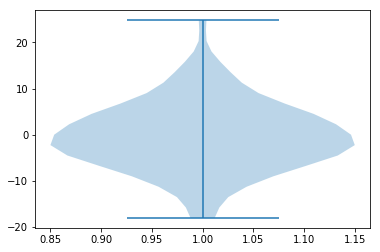

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use
#how to insert multiple violins?
data = np.random.normal(0, 8, size=100)
plt.violinplot(data, [1], points=20, widths=0.3)
print "sample violin plot"

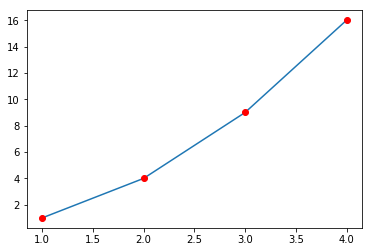

In [40]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

plt.plot([1,2,3,4], [1,4,9,16], 'ro')

(array([   11.,    77.,   358.,  1146.,  2394.,  2759.,  2089.,   886.,
          242.,    38.]),
 array([-3.84996564, -3.13106334, -2.41216104, -1.69325875, -0.97435645,
        -0.25545415,  0.46344815,  1.18235045,  1.90125275,  2.62015505,
         3.33905734]),
 <a list of 10 Patch objects>)

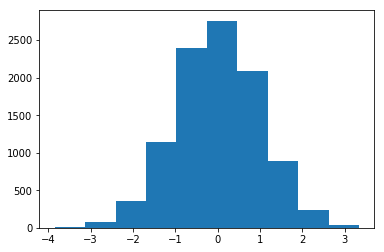

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.hist(np.random.randn(10000))

([<matplotlib.patches.Wedge at 0x7f7162b52dd0>,
  <matplotlib.text.Text at 0x7f7162b616d0>])

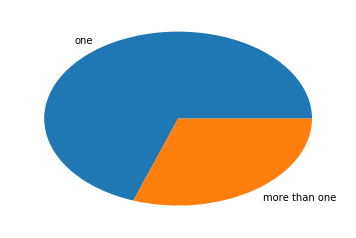

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

from nltk.stem import PorterStemmer
from pyspark.sql.functions import udf, count, col, when, collect_list
from pyspark.sql.types import StructField, StructType, StringType

field = StructField("word", StringType(), False)
schema = StructType([field])
stemmer = udf(lambda val: PorterStemmer().stem(val), StringType())
pie_data = spark.read\
                 .csv("/usr/share/dict/american-english", schema=schema)\
                 .select("word", stemmer("word").alias("stemmed"))\
                 .groupby("stemmed")\
                 .agg(count("stemmed").alias("counts"))\
                 .groupby(when(col("counts") > 1, "more than one").otherwise("one").alias("status"))\
                 .agg(count("*").alias("counts"))\
                 .select(collect_list("status").alias("status"), 
                         collect_list("counts").alias("counts"))\
                 .collect()[0]

                
plt.pie(x=pie_data.counts, labels=pie_data.status)
#print pie_data